In [3]:
# Step 1 - Setup & Load the Dataset
import pandas as pd

# 1.1 Load
df = pd.read_csv('/Users/yashsoni/Documents/data_stories_one_shot.csv')   # ← change to your actual filename
# 1.2 Quick look & cleanup
print(df.shape)
display(df.head())
df = df.dropna()   # drop rows with missing values (or impute, if preferred)

(130, 4)


,Plot_Name,Stage,Quality,Sentence
0,walk dog,1,1.0,This is a line chart with error bars.
1,walk dog,1,1.0,The chart title is 'Walk dog'.
2,walk dog,1,1.0,The y-axis represents 'Mean anxiety'.
3,walk dog,1,1.0,The x-axis indicates conditions such as 'Basel...
4,walk dog,1,1.0,The chart compares mean anxiety levels with an...


In [8]:
# Step 2 - Data Preprocessing: Standardize to Zero-Mean
import numpy as np
from sklearn.preprocessing import StandardScaler

# 2.1 Select only numeric columns (PCA needs numbers)
numeric_cols = df.select_dtypes(include=[np.number]).columns  
X_numeric   = df[numeric_cols]

# 2.2 Standardize (zero mean, unit variance)
scaler = StandardScaler()
X_std  = scaler.fit_transform(X_numeric)

In [9]:
from sklearn.decomposition import PCA

pca   = PCA()            # compute all PCs
X_pca = pca.fit_transform(X_std)
# X_pca.shape == (n_samples, n_features)

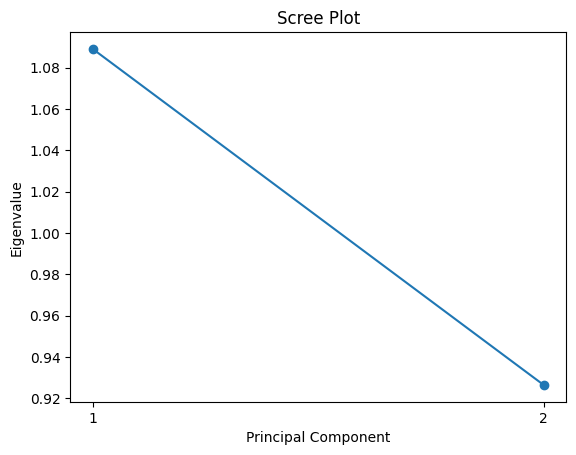

PC1–PC1: 54.03% variance explained
PC1–PC2: 100.00% variance explained

Choosing k = 2 (retains 100.00% of variance)


In [12]:
# Scree Plot and Explained Variance

import matplotlib.pyplot as plt

# 4.1 Eigenvalues and variance ratios
eigenvals = pca.explained_variance_
var_ratio = pca.explained_variance_ratio_

# 4.2 Scree plot of eigenvalues
plt.figure()
plt.plot(range(1, len(eigenvals)+1), eigenvals, 'o-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, len(eigenvals)+1))
plt.show()

# 4.3 Cumulative variance explained
cumvar = var_ratio.cumsum()
for i, cv in enumerate(cumvar, start=1):
    print(f"PC1–PC{i}: {cv:.2%} variance explained")

# 4.4 Programmatic choice of k for, say, 90% retention
import numpy as np
desired_variance = 0.90
k = np.argmax(cumvar >= desired_variance) + 1
print(f"\nChoosing k = {k} (retains {cumvar[k-1]:.2%} of variance)")

In [13]:
# Step 5 - Output the Transformed Dataset

# 5.1 Build a DataFrame of the first k principal components
df_pca = pd.DataFrame(
    X_pca[:, :k],
    columns=[f'PC{i}' for i in range(1, k+1)]
)

print(f"Using k = {k} components:")
display(df_pca.head())

Using k = 2 components:


,PC1,PC2
0,0.789209,-0.303542
1,0.789209,-0.303542
2,0.789209,-0.303542
3,0.789209,-0.303542
4,0.789209,-0.303542


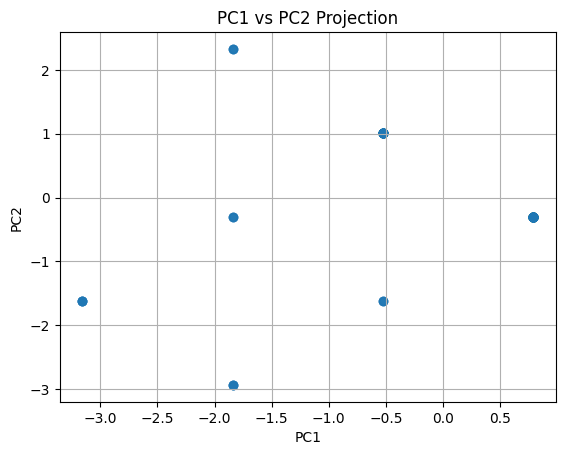

In [18]:
# Step 6 - Scatter Plot of PC1 vs. PC2 & Interpretation
plt.figure()
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.7)
plt.title('PC1 vs PC2 Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()


In [21]:
# Question 3 - Feature selection 

import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler

# 1. Load & clean the data
df = pd.read_csv('/Users/yashsoni/Documents/BMI.csv')
df.dropna(inplace=True)

# 2. Drop age and split into X (features) and y (target)
if 'Age' in df.columns:
    df = df.drop(columns=['Age'])
elif 'age' in df.columns:
    df = df.drop(columns=['age'])
y = df['fatpctg']
X = df.drop(columns=['fatpctg'])
features = X.columns.tolist()

# How many top features to select
n = 5

# 3. Wrapper method: RFE with LinearRegression
rfe = RFE(estimator=LinearRegression(), n_features_to_select=n)
rfe.fit(X, y)
top_wrapper = [f for f, s in zip(features, rfe.support_) if s]

# 4. Embedded method: LassoCV
X_std = StandardScaler().fit_transform(X)
lasso = LassoCV(cv=5, random_state=0).fit(X_std, y)
coef_imp = pd.Series(np.abs(lasso.coef_), index=features)
top_embedded = coef_imp.nlargest(n).index.tolist()

# 5. Filter method: Univariate F-test
filter_k = SelectKBest(score_func=f_regression, k=n)
filter_k.fit(X, y)
f_scores = pd.Series(filter_k.scores_, index=features)
top_filter = f_scores.nlargest(n).index.tolist()

# 6. Compile results
results = pd.DataFrame({
    'Wrapper (RFE)': pd.Series(top_wrapper),
    'Embedded (Lasso)': pd.Series(top_embedded),
    'Filter (F-test)': pd.Series(top_filter)
})
print(results)

  Wrapper (RFE) Embedded (Lasso) Filter (F-test)
0          Neck          Abdomen         Abdomen
1       Abdomen           Weight           Chest
2           Hip              Hip             Hip
3       Forearm            Wrist          Weight
4         Wrist             Neck           Thigh
